# HabiTerre Assessment Data Engineer Position


### Required Libraries

In [1]:
#importing required libraries 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import scipy
from PIL import Image
import os
import rasterio as rs
from rasterio.plot import show
from osgeo import gdal
from matplotlib import gridspec
import time
from patchify import patchify,unpatchify
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import MeanIoU
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()
from sklearn.model_selection import train_test_split
import random
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU

Segmentation Models: using `keras` framework.


In [2]:
# pip install segmentation-models

In [3]:
# RASTERIO download files 
#makes sure the verison is same as python version and computer bits, took about 4 hours, 
#and had to reset all setttings to fix the problem
#thanking youtuber for help me fix my issue. here is the link #https://www.youtube.com/watch?v=GRyBR--2zFo
#install GDAL all core compenents 
#install GDAL for python 3.6
#edit your environmental path and set the folder GDAL to it.
#activiate your virtual enviorment and install the files.
# pip install GDAL-3.1.4-cp36-cp36m-win_amd64.whl
# pip install rasterio-1.1.8-cp36-cp36m-win_amd64.whl
#These are the files I need since I have python 3.6, tensorflow-gpu 2.6 to run Rasterio


In [4]:
# change your directory as needed.. 
os.chdir(r"C:\Users\mistr\Downloads\data")

### Labeled Image Visualization

Count:  1
Height and widht:  1942 1535
CRS EPSG:32616
bounds:  BoundingBox(left=374955.0, bottom=4414815.0, right=421005.0, top=4473075.0)


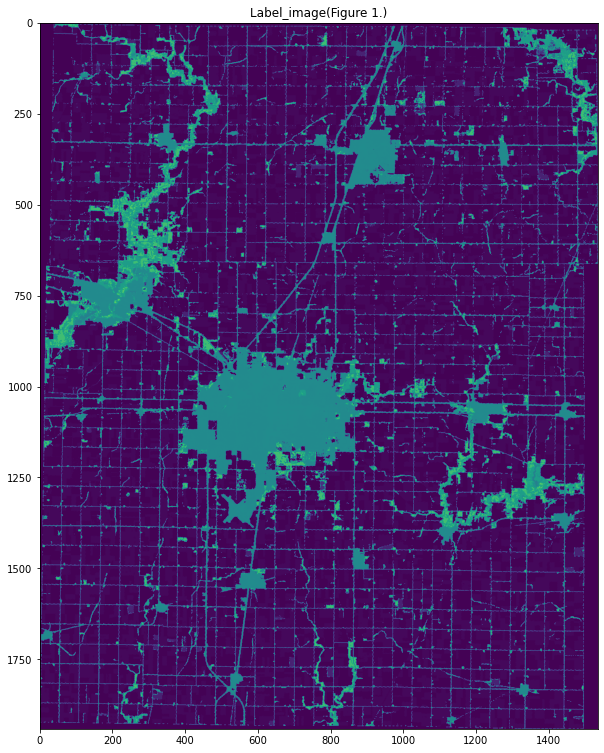

In [5]:
#looking at the data for first time..
#this is CDL image with (30,30)shape
file_loc =  os.getcwd() + "\CDL.tif"
label_img = rs.open(file_loc)
#show(img)
plt.figure(figsize=(10,20))
plt.title("Label_image(Figure 1.)")
plt.imshow(label_img.read(1))

print("Count: ",label_img.count)
print("Height and widht: ", label_img.height ,label_img.width)
print("CRS", label_img.crs)
print("bounds: ",label_img.bounds)

In [6]:
#information on the image using rasterio in-built function
label_img.profile

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 1535, 'height': 1942, 'count': 1, 'crs': CRS.from_epsg(32616), 'transform': Affine(30.0, 0.0, 374955.0,
       0.0, -30.0, 4473075.0), 'tiled': False, 'interleave': 'band'}

### Rapid Eye Visualization 

Count:  5
Height and widht:  11652 9210
CRS EPSG:32616
bounds:  BoundingBox(left=374955.0, bottom=4414815.0, right=421005.0, top=4473075.0)


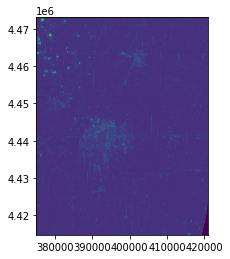

<AxesSubplot:>

In [7]:
#Input data visualization
#input shape(5,5) with 5 spectral bands
file_loc_rapid =  os.getcwd() +  "\RapidEye.tif"
Rapideye_img = rs.open(file_loc_rapid)
print("Count: ",Rapideye_img.count)
print("Height and widht: ", Rapideye_img.height ,Rapideye_img.width)
print("CRS", Rapideye_img.crs)
print("bounds: ",Rapideye_img.bounds)
show(Rapideye_img)

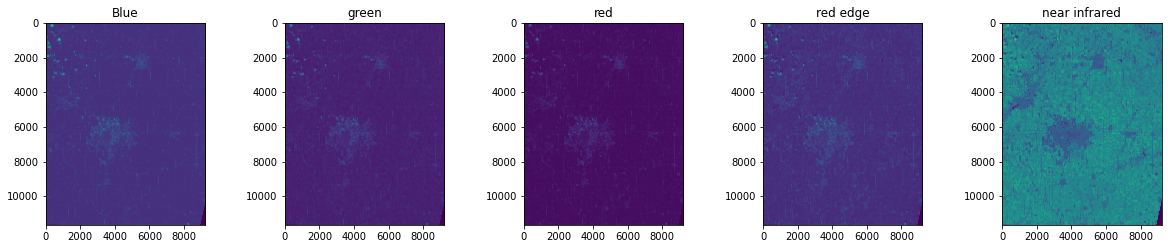

In [8]:
#visualizing all the spectral bands individually
display_name = ["Blue", "green", "red", "red edge", "near infrared"]
fig = plt.figure()
# to change size of subplot's
fig.set_figheight(20)
fig.set_figwidth(20)

spec = gridspec.GridSpec(ncols=5, nrows=1,wspace=0.5,
                         hspace=0.5)
n_cols = 5
for index in range(n_cols):
    ax = fig.add_subplot(spec[index])
    ax.title.set_text(display_name[index])
    ax.imshow(Rapideye_img.read(index+1))
plt.show()

In [9]:
#Not sure why, assuming the assessment info is correct with the color inerpretation
Rapideye_img.colorinterp

(<ColorInterp.gray: 1>,
 <ColorInterp.undefined: 0>,
 <ColorInterp.undefined: 0>,
 <ColorInterp.undefined: 0>,
 <ColorInterp.undefined: 0>)

In [10]:
#information on image using rasterio in-built function
Rapideye_img.profile

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 9210, 'height': 11652, 'count': 5, 'crs': CRS.from_epsg(32616), 'transform': Affine(5.0, 0.0, 374955.0,
       0.0, -5.0, 4473075.0), 'tiled': False, 'interleave': 'pixel'}

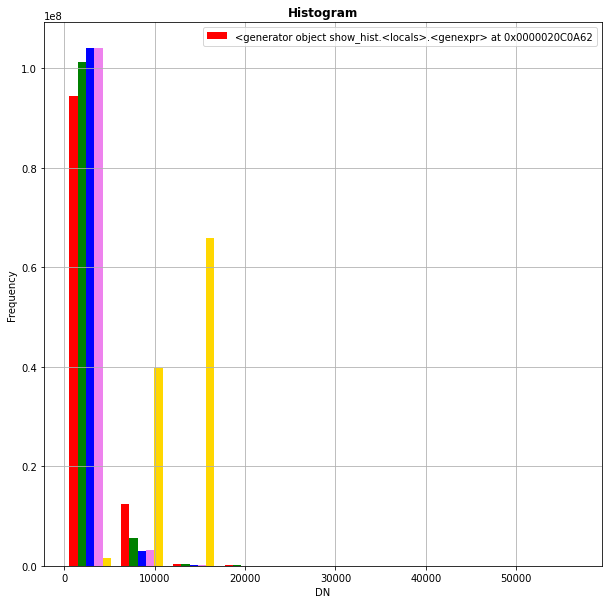

In [11]:
#Histogram to see how bands are distrubuted
plt.figure(figsize=(10,10))
rs.plot.show_hist(Rapideye_img)
plt.show()

### NDVI (Normalizing Difference vegetation Index)

In [12]:
#Calculating NDVI

red = Rapideye_img.read(4)
nir = Rapideye_img.read(5)

red = red.astype(float)
nir = nir.astype(float)


np.seterr(divide='ignore', invalid='ignore')

ndvi = np.empty(Rapideye_img.shape, dtype=rs.float32)
ndvi = np.nan_to_num(ndvi, nan=-1)
check = np.logical_or ( red > 0, nir > 0 )

ndvi = np.where ( check,  (nir - red ) / ( nir + red ), -999 )

NDVI mean:  -3.10172069911947
NDVI Std:  59.88274864663295


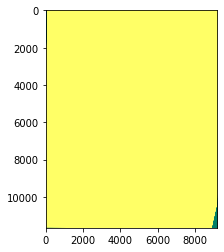

<AxesSubplot:>

In [13]:
print("NDVI mean: ", ndvi.mean())
print("NDVI Std: ", ndvi.std())
show(ndvi, cmap='summer')

### Resampling labeled Imaged to input data using QGIS

Count:  4
Height and widht:  11652 9210
CRS EPSG:32616
bounds:  BoundingBox(left=374955.0, bottom=4414815.0, right=421005.0, top=4473075.0)


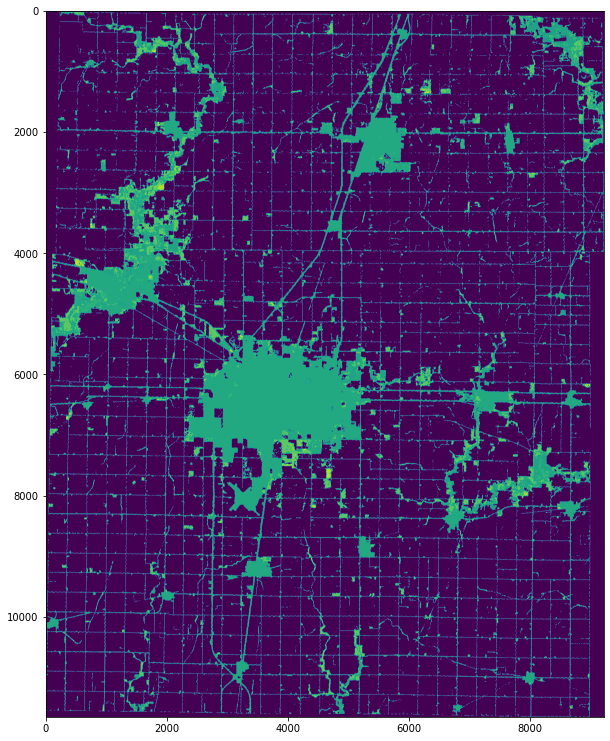

In [14]:
#Resampling it using QGIS software with in-built function.
file_loc_resampled = os.getcwd() + "\CDL_resampled.tif"
label_img_resampled = rs.open(file_loc_resampled)
#show(img)
plt.figure(figsize=(10,20))
plt.imshow(label_img_resampled.read(3))

print("Count: ",label_img_resampled.count)
print("Height and widht: ", label_img_resampled.height ,label_img_resampled.width)
print("CRS", label_img_resampled.crs)
print("bounds: ",label_img_resampled.bounds)

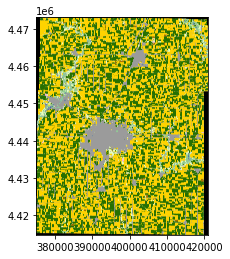

<AxesSubplot:>

In [15]:
rs.plot.show(label_img_resampled)

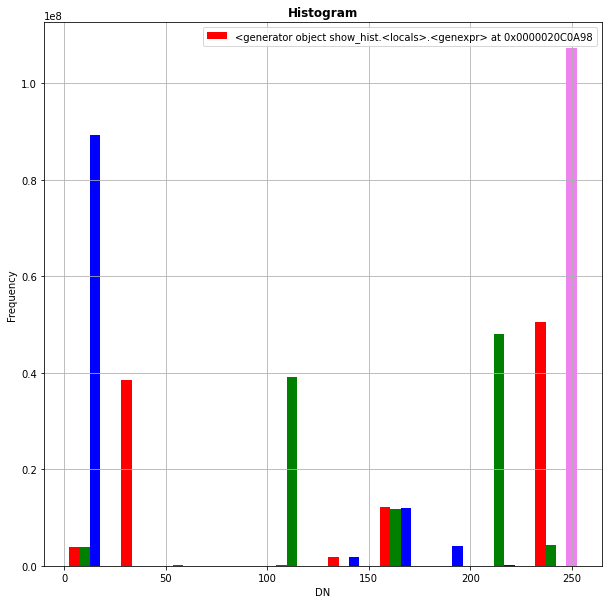

In [16]:
#historgram to check distrubution of spectral bands
plt.figure(figsize=(10,10))
rs.plot.show_hist(label_img_resampled)
plt.show()

### Data

In [17]:
# pip install patchify
#using this library to divide the image into small images to help process faster

In [18]:
### Features for the data
with rs.open(file_loc_rapid, 'r') as file:
    arr_st = file.read()
# Data
# arr_st = np.stack(features)
features = np.moveaxis(arr_st, 0, -1)

print(features.shape)

# savemat(file_name='sundarbans_bands.mat', mdict={"data": arr_st })

(11652, 9210, 5)


In [19]:
#labels for the data
with rs.open(file_loc_resampled, 'r') as file:
    arr_st_label = file.read()
# Data
# arr_st = np.stack(features)
label = np.moveaxis(arr_st_label, 0, -1)

print(label.shape)

(11652, 9210, 4)


In [20]:
image_dataset = []
patch_size = 256
patches_img = patchify(features, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap
        
for i in range(patches_img.shape[0]):
    for j in range(patches_img.shape[1]):

        single_patch_img = patches_img[i,j,:,:]

        #Use minmaxscaler instead of just dividing by 255. 
        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)

        #single_patch_img = (single_patch_img.astype('float32')) / 255. 
        single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds.                               
        image_dataset.append(single_patch_img)

In [21]:
len(image_dataset)

1575

In [22]:
mask_dataset = []
patches_mask = patchify(label, (patch_size, patch_size,3), step=patch_size)  #Step=256 for 256 patches means no overlap
        
for i in range(patches_mask.shape[0]):
    for j in range(patches_mask.shape[1]):

        single_patch_mask = patches_mask[i,j,:,:]
        #single_patch_img = (single_patch_img.astype('float32')) / 255. #No need to scale masks, but you can do it if you want
        single_patch_mask = single_patch_mask[0] #Drop the extra unecessary dimension that patchify adds.                               
        mask_dataset.append(single_patch_mask) 

In [23]:
len(mask_dataset)

1575

In [24]:
image_dataset = np.array(image_dataset)
mask_dataset =  np.array(mask_dataset)

In [25]:
# mask_dataset[0]

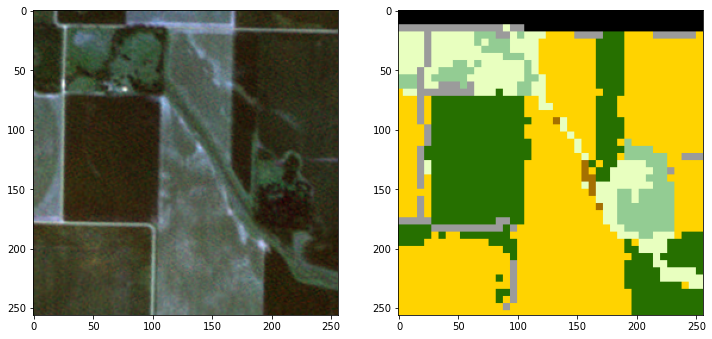

In [26]:
#visualizing the image to see if they are patch with correct label (no neccessary but to be sure)
image_number = 2
# random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(image_dataset[image_number], (patch_size, patch_size, 3)))
plt.subplot(122)
plt.imshow(np.reshape(mask_dataset[image_number], (patch_size, patch_size, 3)))
plt.show()

1. This is from cropland data layer dataset details. since the sementic segmentation is pixel wise classification, I need more information on the colors and their actually hexadecimal form.
2. This is screenshot from the website, since I am using only corn and soybean for this.. I didnt upload full chart.
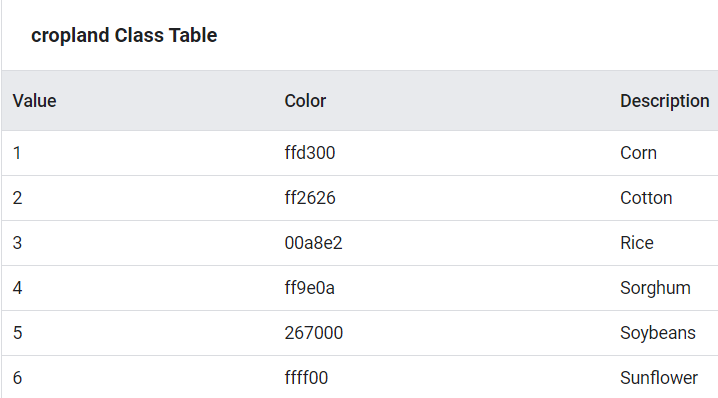

In [27]:
#hexadecimal to INteger
#base: 16, 
#0-9 , 10-15 -> A-F

Corn = '#ffd300'.lstrip('#')
Corn = np.array(tuple(int(Corn[i:i+2], 16) for i in (0, 2, 4))) 

Soybean = '#267000'.lstrip('#')
Soybean = np.array(tuple(int(Soybean[i:i+2], 16) for i in (0, 2, 4))) 



In [28]:
def rgb_to_2D_label(label):

    label_seg = np.zeros(label.shape,dtype=np.uint8)
    label_seg [np.all(label == Corn,axis=-1)] = 1
    label_seg [np.all(label==Soybean,axis=-1)] = 2
#     label_seg [np.all(label == "any",axis=-1)] = 2
    
    label_seg = label_seg[:,:,0]  #Just take the first channel, no need for all 3 channels
    
    return label_seg

In [29]:
labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_2D_label(mask_dataset[i])
    labels.append(label)    

labels = np.array(labels)   
labels = np.expand_dims(labels, axis=3)

Unique labels in label dataset are:  [0 1 2]


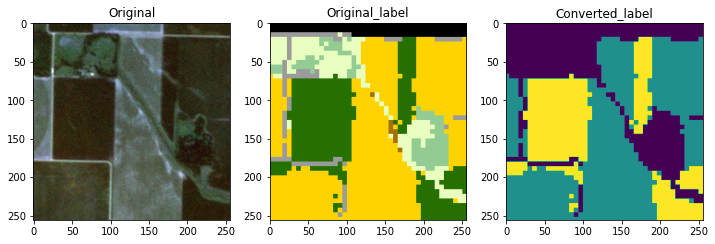

In [30]:
print("Unique labels in label dataset are: ", np.unique(labels))

#Another Sanity check, view few mages
import random
import numpy as np
image_number = 2 
# random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(131)
plt.title("Original")
plt.imshow(image_dataset[image_number])
plt.subplot(132)
plt.title("Original_label")
plt.imshow(np.reshape(mask_dataset[image_number], (patch_size, patch_size, 3)))
plt.subplot(133)
plt.title("Converted_label")
plt.imshow(labels[image_number][:,:,0])
plt.show()

1. this is how the classification looks after converting color hex to integer.
2.  compare the converted image to original label

In [31]:
#making into one-hot encoding since the array has integers
n_classes = len(np.unique(labels))
print(n_classes)
labels_cat = to_categorical(labels, num_classes=n_classes)

3


In [32]:
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.20, random_state = 42)

print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(1260, 256, 256, 3)
(1260, 256, 256, 3)
(315, 256, 256, 3)
(315, 256, 256, 3)


## Model#1 custom-vanilla-unet`

In [33]:
# #using keras-unet to use Vanilla-unet 
# # pip install git+https://github.com/karolzak/keras-unet

# from keras_unet.models import custom_unet

# model = custom_unet(
#     input_shape=(256, 256, 3),
#     num_classes=3,
#     filters=64,
#     dropout=0.2,
#     output_activation='softmax')

In [34]:
# optimizer = tf.keras.optimizers.Adam(learning_rate= 0.001)
# model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics= ["accuracy"])
# model.summary()

In [35]:
# history = model.fit(X_train, y_train, 
#                     batch_size = 4, 
#                     verbose=1, 
#                     epochs=10, 
#                     validation_data=(X_test, y_test), 
#                     shuffle=False)

In [36]:
# loss = history.history['loss']
# val_loss = history.history['val_loss']
# epochs = range(1, len(loss) + 1)
# plt.plot(epochs, loss, 'y', label='Training loss')
# plt.plot(epochs, val_loss, 'r', label='Validation loss')
# plt.title('Training and validation loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

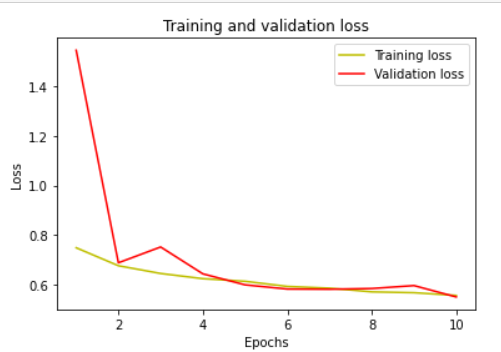

In [37]:
# loss = history.history['accuracy']
# val_loss = history.history['val_accuracy']
# epochs = range(1, len(loss) + 1)
# plt.plot(epochs, loss, 'y', label='Training loss')
# plt.plot(epochs, val_loss, 'r', label='Validation loss')
# plt.title('Training and validation loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

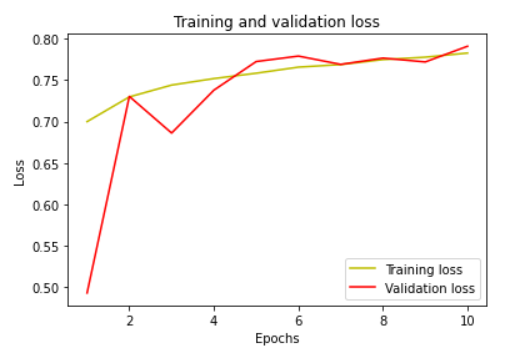

In [38]:
# from tensorflow import keras
# model_u = keras.models.load_model(r"C:\Users\mistr\Downloads\data\my_model")

In [39]:
# y_pred=model.predict(X_test)
# y_pred_argmax=np.argmax(y_pred, axis=3)
# y_test_argmax=np.argmax(y_test, axis=3)

In [40]:
# import random
# test_img_number = random.randint(0, len(X_test))
# test_img = X_test[test_img_number]
# ground_truth=y_test_argmax[test_img_number]
# #test_img_norm=test_img[:,:,0][:,:,None]
# test_img_input=np.expand_dims(test_img, 0)
# prediction = (model.predict(test_img_input))
# predicted_img=np.argmax(prediction, axis=3)[0,:,:]

In [41]:
# plt.figure(figsize=(12, 8))
# plt.subplot(231)
# plt.title('Testing Image')
# plt.imshow(test_img)
# plt.subplot(232)
# plt.title('Testing Label')
# plt.imshow(ground_truth)
# plt.subplot(233)
# plt.title('Prediction on test image')
# plt.imshow(predicted_img)
# plt.show()

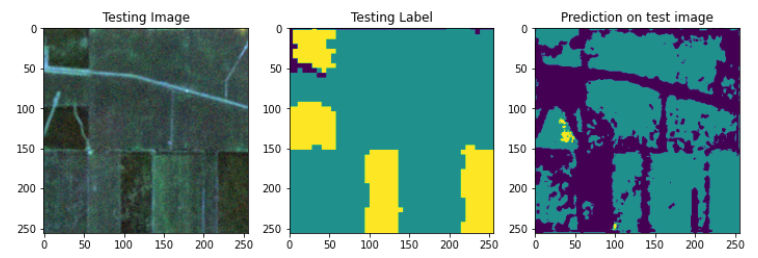

##  Model#2: unet-Resnet34 with imagenet weights 

### modeling

In [42]:
#using resnet backbone on unet with imagenet weights 
sm.set_framework('tf.keras')

sm.framework()

BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

# preprocess input
X_train_prepr = preprocess_input(X_train)
X_test_prepr = preprocess_input(X_test)

# define model
model_resnet_backbone = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=n_classes, activation='softmax')


In [43]:
from keras import backend as K
def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

metrics=['accuracy', jacard_coef]

In [44]:
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=1e-2,
#     decay_steps=10000,
#     decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate= 0.0001)

In [45]:
model_resnet_backbone.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics= metrics)

print(model_resnet_backbone.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, None, None,  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, None, None, 3 9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, None, None, 3 0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, None, None, 6 9408        zero_padding2d[0][0]             
____________________________________________________________________________________________

In [46]:
history2=model_resnet_backbone.fit(X_train_prepr, 
          y_train,
          batch_size=4, 
          epochs=10,
          verbose=1,
          validation_data=(X_test_prepr, y_test))

Epoch 1/10
315/315 [==============================] - 38s 84ms/step - loss: 0.7561 - accuracy: 0.6814 - jacard_coef: 0.3897 - val_loss: 1.4274 - val_accuracy: 0.3684 - val_jacard_coef: 0.2081
Epoch 2/10
315/315 [==============================] - 25s 79ms/step - loss: 0.5269 - accuracy: 0.7969 - jacard_coef: 0.5302 - val_loss: 1.1957 - val_accuracy: 0.3343 - val_jacard_coef: 0.1997
Epoch 3/10
315/315 [==============================] - 25s 80ms/step - loss: 0.4562 - accuracy: 0.8299 - jacard_coef: 0.5842 - val_loss: 1.2462 - val_accuracy: 0.3022 - val_jacard_coef: 0.2064
Epoch 4/10
315/315 [==============================] - 25s 80ms/step - loss: 0.4033 - accuracy: 0.8503 - jacard_coef: 0.6228 - val_loss: 0.7891 - val_accuracy: 0.7008 - val_jacard_coef: 0.4709
Epoch 5/10
315/315 [==============================] - 25s 80ms/step - loss: 0.3544 - accuracy: 0.8689 - jacard_coef: 0.6619 - val_loss: 0.3950 - val_accuracy: 0.8537 - val_jacard_coef: 0.6244
Epoch 6/10
315/315 [====================

In [47]:
# history = history2

In [48]:

# loss = history.history['loss']
# val_loss = history.history['val_loss']
# epochs = range(1, len(loss) + 1)
# plt.plot(epochs, loss, 'y', label='Training loss')
# plt.plot(epochs, val_loss, 'r', label='Validation loss')
# plt.title('Training and validation loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

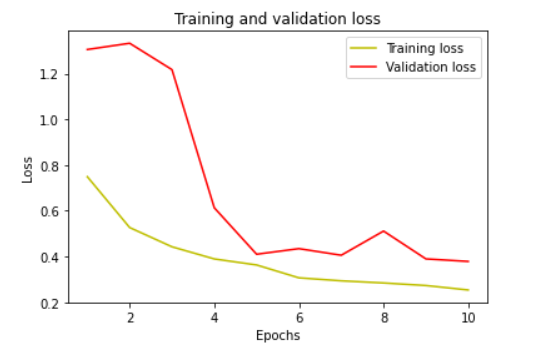

In [49]:
# loss = history.history['accuracy']
# val_loss = history.history['val_accuracy']
# epochs = range(1, len(loss) + 1)
# plt.plot(epochs, loss, 'y', label='Training accuracy')
# plt.plot(epochs, val_loss, 'r', label='Validation accuracy')
# plt.title('Training and validation accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('accuracy')
# plt.legend()
# plt.show()

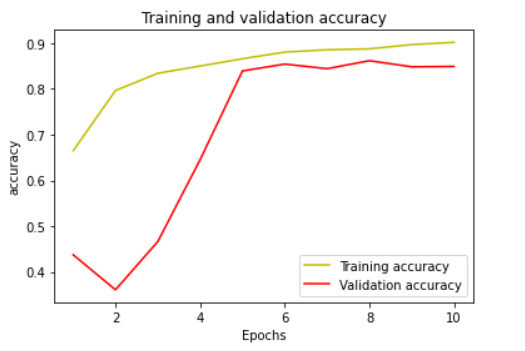

In [50]:
# model_resnet_backbone.save("my_model_unet_resnet")

### Model Evaluation

In [51]:
# I am calling save model for further evaluation
# model_resnet = tf.keras.models.load_model("my_model_unet_resnet", custom_objects={'jacard_coef':jacard_coef})

In [52]:
y_pred=model_resnet_backbone.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)

In [53]:
print(jacard_coef(y_test,y_pred))

tf.Tensor(0.6845125, shape=(), dtype=float32)


In [54]:
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_test_argmax,y_pred_argmax)
print(IOU_keras.result().numpy())

0.72453886


In [55]:
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
    return dice

In [56]:
print (dice_coef(y_test,y_pred).numpy())

0.8127143


In [57]:
import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test_argmax[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model_resnet_backbone.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]

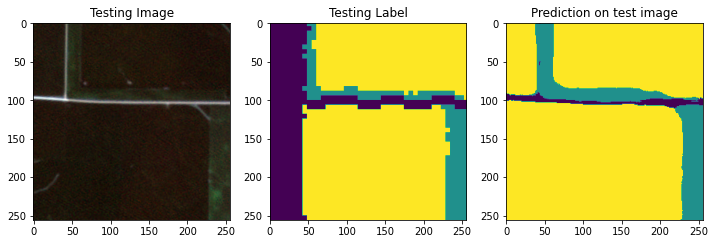

In [58]:
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()

## Test set prediction

In [59]:
patches_img.shape

(45, 35, 1, 256, 256, 3)

In [60]:
predicted_patches = []
for i in range(patches_img.shape[0]):
    for j in range(patches_img.shape[1]):
#         print(i,j)
        
        single_patch = patches_img[i,j,:,:,:]
#         print(single_patch.shape)
        single_patch_norm = scaler.fit_transform(single_patch.reshape(-1, single_patch.shape[-1])).reshape(single_patch.shape) 
        single_patch_input= np.expand_dims(single_patch_norm[0],0)
#         print(single_patch_input.shape)

#Predict and threshold for values above 0.5 probability
        single_patch_prediction = (model_resnet_backbone.predict(single_patch_input)[0,:,:,0] > 0.5).astype(np.uint8)
        predicted_patches.append(single_patch_prediction)

predicted_patches = np.array(predicted_patches)




In [61]:
predicted_patches_reshaped = np.reshape(predicted_patches, (patches_img.shape[0], patches_img.shape[1], 256,256) )
reconstructed_image = unpatchify(predicted_patches_reshaped, (45*256,35*256))


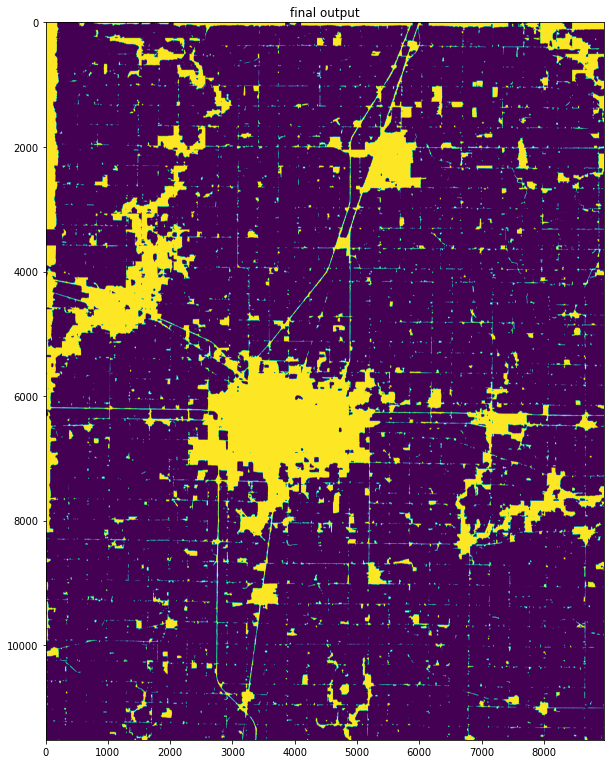

In [62]:
plt.figure(figsize=(10,20))
plt.title("final output")
plt.imshow(reconstructed_image)
# plt.imsave('data/results/segm.jpg', reconstructed_image, cmap='gray')

# plt.hist(reconstructed_image.flatten())  #Threshold everything above 0

In [64]:
# plt.imsave("recontructed_image.tiff", reconstructed_image)